## **Imports**

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, make_scorer, f1_score, precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from pylab import get_cmap
import seaborn

from os import path, makedirs
from itertools import combinations
from re import sub, compile

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
path = "/content/gdrive/MyDrive/Article_Classification/train.csv"
data = pd.read_csv(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Zmiana nazw kolumn**

In [ ]:
data['labels'] = data.apply(lambda x: list([x['Computer Science'], x['Physics'], x['Mathematics'], x['Statistics'], x['Quantitative Biology'], x['Quantitative Finance']]),axis=1) 

**Usunięcie artykułów multidyscyplinarnych oraz dodanie kolumny etykiety**

In [ ]:
for index, row in data.iterrows():
  if row['labels'].count(1) != 1:
    data=data.drop(index)

In [ ]:
def modify2(label):
  x = label.index(max(label))+1
  return x
  round1 = lambda x: modify2(x)
data['labels'] = data['labels'].apply(modify2)

In [ ]:
data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,labels
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,3
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,3
5,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0,3


# **Wstępne przetwarzanie tekstu**



*   **Zmniejszenie tekstu do małych liter**
*   **Usuwanie: '\n', usuwanie tekstu w nawiasach kwadratowych**





In [ ]:
def clean_text(text):
   
    if isinstance(text, str):
      # Remove new line characters
      text = text.lower()
      text = re.sub('\\n', ' ', text)
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]', ' ', text) #dowolny znak w nawiasie kwadratowym
      text = re.sub('\w+\d\w*', ' ', text) #liczby w środku wyrazu

      return text

round1 = lambda x: clean_text(x)

In [ ]:
data['ABSTRACT'] = data['ABSTRACT'].apply(clean_text)

In [ ]:
data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,labels
0,1,Reconstructing Subject-Specific Effect Maps,predictive model allow ubject- pecific inf...,1,0,0,0,0,0,1
1,2,Rotation Invariance Neural Network,rotation invariance and tran lation invarian...,1,0,0,0,0,0,1
2,3,Spherical polyharmonics and Poisson kernels fo...,we introduce and develop the notion of pher...,0,0,1,0,0,0,3
3,4,A finite element approximation for the stochas...,the tocha tic landau--lif hitz--gilbert (ll...,0,0,1,0,0,0,3
5,6,On maximizing the fundamental frequency of the...,let $\omega \ ub et \mathbb{r}^n$ be a bound...,0,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
20962,20963,Low-luminosity stellar wind accretion onto neu...,feature and application of qua i- pherical...,0,1,0,0,0,0,2
20965,20966,One-sample aggregate data meta-analysis of med...,an aggregate data meta-analy i i a tati t...,0,0,0,1,0,0,4
20966,20967,QuickCast: Fast and Efficient Inter-Datacenter...,large inter-datacenter tran fer are crucial...,1,0,0,0,0,0,1
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,polycry talline diamond coating have been g...,0,1,0,0,0,0,2


**Przeprowadzamy tokenizacje i lematyzacje tekstu oraz usuwamy słowa, które nie wnoszą dużego znaczenia, są to np. łączniki: i, a, że itd.**

Lematyzacja to proces przekształcania danego słowa w jego formę bazową zgodnie ze słownikowym znaczeniem tego słowa. Lematyzacja zajmuje więcej czasu niż stematyzacja, ale zwykle daje lepsze rezultaty. Dlatego będziemy wybierać lematyzację.



In [ ]:
stop_words = set(stopwords.words('english'))

# Creating a list of custom stopwords
lmtzr = WordNetLemmatizer()

def pre_process(text):
  text = nltk.word_tokenize(text)
  text = [lmtzr.lemmatize(word) for word in text if word not in stop_words]
  if len(text) > 2:
    return ' '.join(text)


In [ ]:
data['ABSTRACT'] = data['ABSTRACT'].apply(lambda x : pre_process(x))
data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,labels
0,1,Reconstructing Subject-Specific Effect Maps,predictive model allow ubject- pecific inferen...,1,0,0,0,0,0,1
1,2,Rotation Invariance Neural Network,rotation invariance tran lation invariance gre...,1,0,0,0,0,0,1
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion pherical polyharmonic...,0,0,1,0,0,0,3
3,4,A finite element approximation for the stochas...,tocha tic landau -- lif hitz -- gilbert ( llg ...,0,0,1,0,0,0,3
5,6,On maximizing the fundamental frequency of the...,let $ \omega \ ub et \mathbb { r } ^n $ bounde...,0,0,1,0,0,0,3


In [ ]:
data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,labels
0,1,Reconstructing Subject-Specific Effect Maps,predictive model allow ubject- pecific inferen...,1,0,0,0,0,0,1
1,2,Rotation Invariance Neural Network,rotation invariance tran lation invariance gre...,1,0,0,0,0,0,1
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion pherical polyharmonic...,0,0,1,0,0,0,3
3,4,A finite element approximation for the stochas...,tocha tic landau -- lif hitz -- gilbert ( llg ...,0,0,1,0,0,0,3
5,6,On maximizing the fundamental frequency of the...,let $ \omega \ ub et \mathbb { r } ^n $ bounde...,0,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
20962,20963,Low-luminosity stellar wind accretion onto neu...,feature application qua i- pherical ettling ac...,0,1,0,0,0,0,2
20965,20966,One-sample aggregate data meta-analysis of med...,aggregate data meta-analy tati tical method po...,0,0,0,1,0,0,4
20966,20967,QuickCast: Fast and Efficient Inter-Datacenter...,large inter-datacenter tran fer crucial cloud ...,1,0,0,0,0,0,1
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,polycry talline diamond coating grown cemented...,0,1,0,0,0,0,2


**Tworzenie nowej tabeli z wykorzystywanymi danymi**

In [ ]:
new_data = data[['ABSTRACT','labels']]
new_data.head()

,ABSTRACT,labels
0,predictive model allow ubject- pecific inferen...,1
1,rotation invariance tran lation invariance gre...,1
2,introduce develop notion pherical polyharmonic...,3
3,tocha tic landau -- lif hitz -- gilbert ( llg ...,3
5,let $ \omega \ ub et \mathbb { r } ^n $ bounde...,3


**Usuwanie niepełnych danych**

In [ ]:
new_data.dropna(subset=['ABSTRACT'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Wektoryzacja słów z wykorzystaniem metody tfidf**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(new_data.ABSTRACT)
X = X.toarray()

In [ ]:
y=new_data['labels']
print(X.shape)
print(y.shape)

(15927, 10000)
(15927,)


Importujemy klasyfikator bayesowski

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

Podział zbioru na treningowy i testowy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,random_state=123)

Zastosowanie algorytmu Naiwnego Bayesa

In [ ]:
# Applying MultinomialNaiveBayes for classification 
clf = MultinomialNB()
classifier = clf.fit(X_train,y_train)
predict = classifier.predict(X_test)

**Macierz Pomyłek**

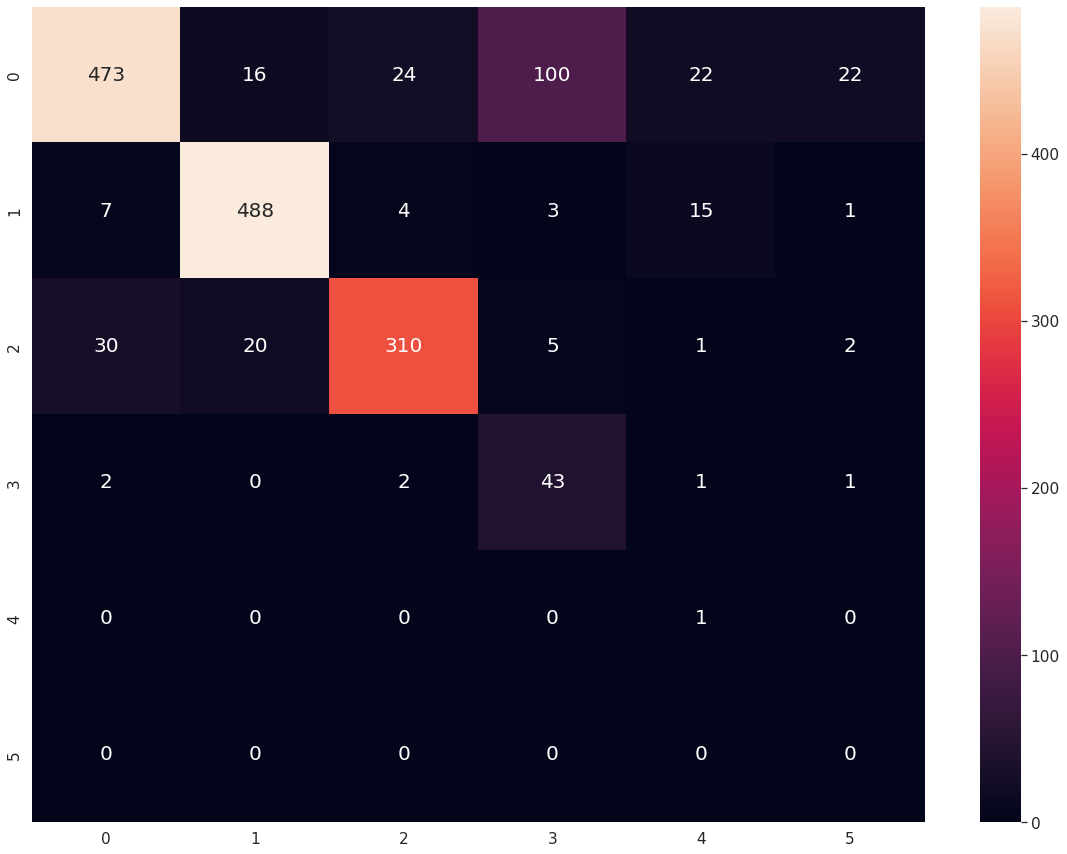

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict,y_test)
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(20,15))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, fmt='d', annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [ ]:
accuracy = cm.trace()/cm.sum()
print(accuracy)

0.8254865034526051


In [ ]:
print('Accuracy: %.3f' %  accuracy_score(y_test, predict)) # (Number of correct predictions / Total number of predictions)

#Przy różnej ilości obserwacji w klasach zwykle używamy parametru micro, jednak poszczególne metryki dają taki sam wynik zatem ich wyświetlanie jest zbędne i wystarczy sprawdzić skuteczność modelu.

print('Precision: %.3f' %  precision_score(y_test, predict, average = 'macro')) #tp / (tp + fp)
print('Recall: %.3f' %  recall_score(y_test,predict, average = 'macro')) #tp / (tp + fn)
print('f1: %.3f' %  f1_score(y_test,predict, average = 'macro')) #F1 = 2 * (precision * recall) / (precision + recall)

Accuracy: 0.825
Precision: 0.730
Recall: 0.513
f1: 0.517


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Podejście 2 - Zmiana parametru z prawd. apriori**

In [ ]:
clf = MultinomialNB(fit_prior=False)
classifier = clf.fit(X_train,y_train)
predict = classifier.predict(X_test)

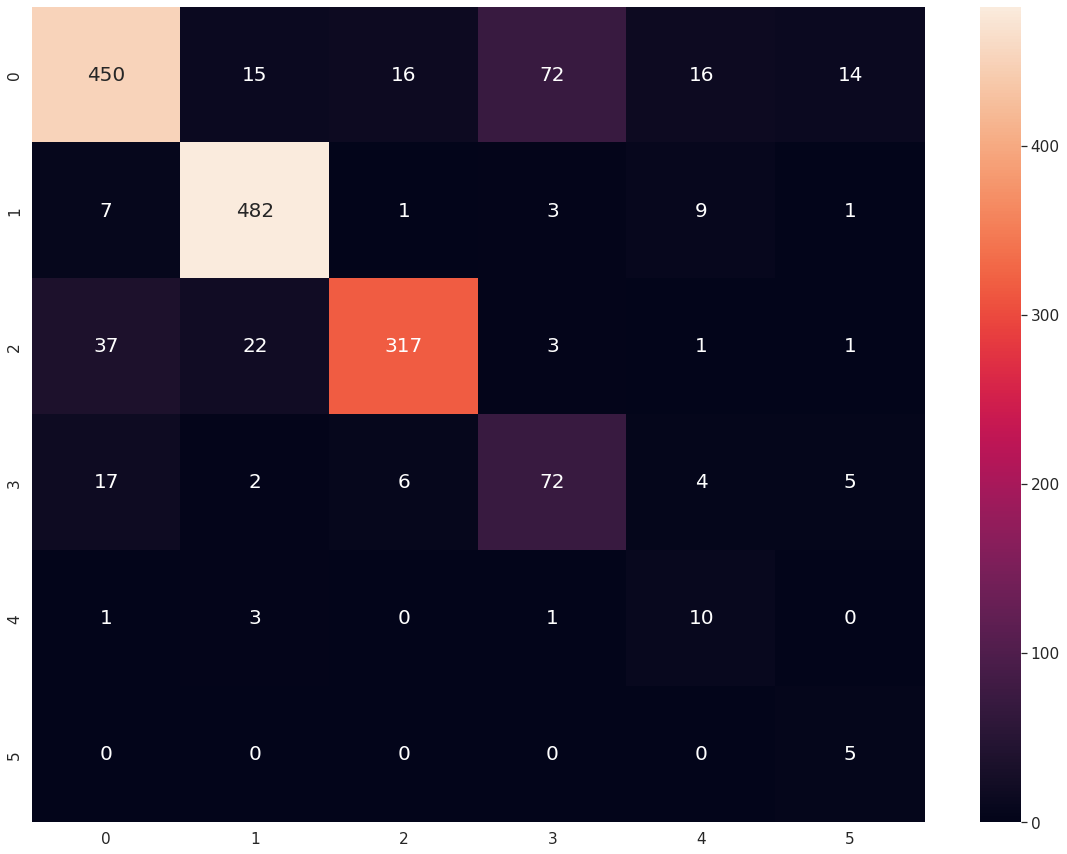

In [ ]:
cm = confusion_matrix(predict,y_test)
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(20,15))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, fmt='d', annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [ ]:
print('Accuracy: %.3f' %  accuracy_score(y_test, predict)) # (Number of correct predictions / Total number of predictions)

#Przy różnej ilości obserwacji w klasach zwykle używamy parametru micro, jednak poszczególne metryki dają taki sam wynik zatem ich wyświetlanie jest zbędne i wystarczy sprawdzić skuteczność modelu.

print('Precision: %.3f' %  precision_score(y_test, predict, average = 'macro')) #tp / (tp + fp)
print('Recall: %.3f' %  recall_score(y_test,predict, average = 'macro')) #tp / (tp + fn)
print('f1: %.3f' %  f1_score(y_test,predict, average = 'macro')) #F1 = 2 * (precision * recall) / (precision + recall)

Accuracy: 0.839
Precision: 0.818
Recall: 0.608
f1: 0.648


In [ ]:
accuracy = cm.trace()/cm.sum()
print(accuracy)

0.8386691776522285
